In [306]:

import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as mvn
from scipy.sparse import identity
#from autograd import grad

In [307]:

def rastrigin(theta):
    n = len(theta)
    A = 10
    loss = A*n
    for i in range(n):
        loss += theta[i]**2 - A*np.cos(2*np.pi*theta[i])
    return loss

def stybtang(theta):
    n = len(theta)
    loss = 0
    for i in range(n):
        loss += (theta[i]**4 - 16*(theta[i]**2) + 5*theta[i])/2
    return loss

def levy(theta):
    n = len(theta)
    w = np.zeros_like(theta)
    for i in range(n):
        w[i] = 1 + (theta[i] - 1)/4

    loss = (np.sin(np.pi*w[0]))**2 + (w[-1] - 1)**2 * (1 + (np.sin(2*np.pi*w[-1]))**2)
    for i in range(n-1):
        loss += (w[i] - 1)**2 * (1 + 10*(np.sin(np.pi*w[i] + 1))**2)
    
    return loss

def ackley(theta):
    loss = -20*np.exp(-0.2*np.sqrt(0.5*(theta[0]**2 + theta[1]**2))) - np.exp(0.5*(np.cos(2*np.pi*theta[0]) + np.cos(2*np.pi*theta[1]))) + 20 + np.e
    return loss

def keanebump(theta):
    n = len(theta)
    cos2 = np.cos(theta) ** 2
    num2 = (np.sum( cos2**2 ) - 2 * np.prod( cos2 )) ** 2
    denom2 = np.arange( 1., n+1 ).dot( theta**2 )
    return num2 / denom2 + 1e-3*np.linalg.norm(theta)

def rosenbrock(theta):
    a = 1
    b = 100
    loss = (a - theta[0])**2 + b*(theta[1] - theta[0]**2)**2
    return loss

def parabola(theta):
    loss = np.inner(theta, theta)
    return loss

def dparabola(theta):
    grad = 2*theta
    return grad

In [308]:

class OptRes():
    def __init__(self, ntheta: int, niter: int) -> None:
        self.niter = niter
        self.theta_hist = np.zeros((niter, ntheta))
        self.f_hist = np.zeros((niter,))
        self.g_hist = np.zeros((niter,))
        self.cont_hist = np.zeros((niter,))

    def fill(self, i: int, theta: np.ndarray, f: float, g: float, cont: float) -> None:
        self.theta_hist[i, :] = theta
        self.f_hist[i] = f
        self.g_hist[i] = g
        self.cont_hist[i] = cont

In [309]:
def mcdiff_opt(f, df, theta0: np.ndarray, cont0: float) -> OptRes:
    n = len(theta0)
    theta = theta0
    cont = cont0

    niter = 100
    #angle=np.zeros((niter))

    a = 1e-3
    n_mc = 10000

    res = OptRes(n, niter)

    for i in range(niter):
        obj = 0
        grad = np.zeros_like(theta0)
        hess = np.zeros((n, n))

        dtheta_samp = np.zeros((n_mc, n))
        f_samp = np.zeros((n_mc,))

        for j in range(n_mc):
            dtheta_samp[j] = np.squeeze(np.sqrt(cont)*np.random.randn(n, 1))
            f_samp[j] = f(theta + dtheta_samp[j])
            
        for j in range(n_mc):
            obj += f_samp[j]/n_mc
            grad += (dtheta_samp[j]/cont)*(f_samp[j]/n_mc)
            hess += (np.outer(dtheta_samp[j], dtheta_samp[j])/(cont**2) - np.eye(n)/cont)*(f_samp[j]/n_mc)

        truegrad = np.array([-2, 4])

        #print('---')
        #print(obj)
        #print(grad)
        #print(hess)

        #angle[i] = (180/np.pi)*np.arccos(np.dot(grad, truegrad)/(np.linalg.norm(grad)*np.linalg.norm(truegrad)))

        res.fill(i, theta, f(theta), obj, cont)

        #grad = df(theta)
        theta -= (a/((i+1)**0.2))*grad #np.matmul(np.linalg.inv(hess), grad)
    
    return res

[-0.00474126  0.99616184]
100.23886795593015


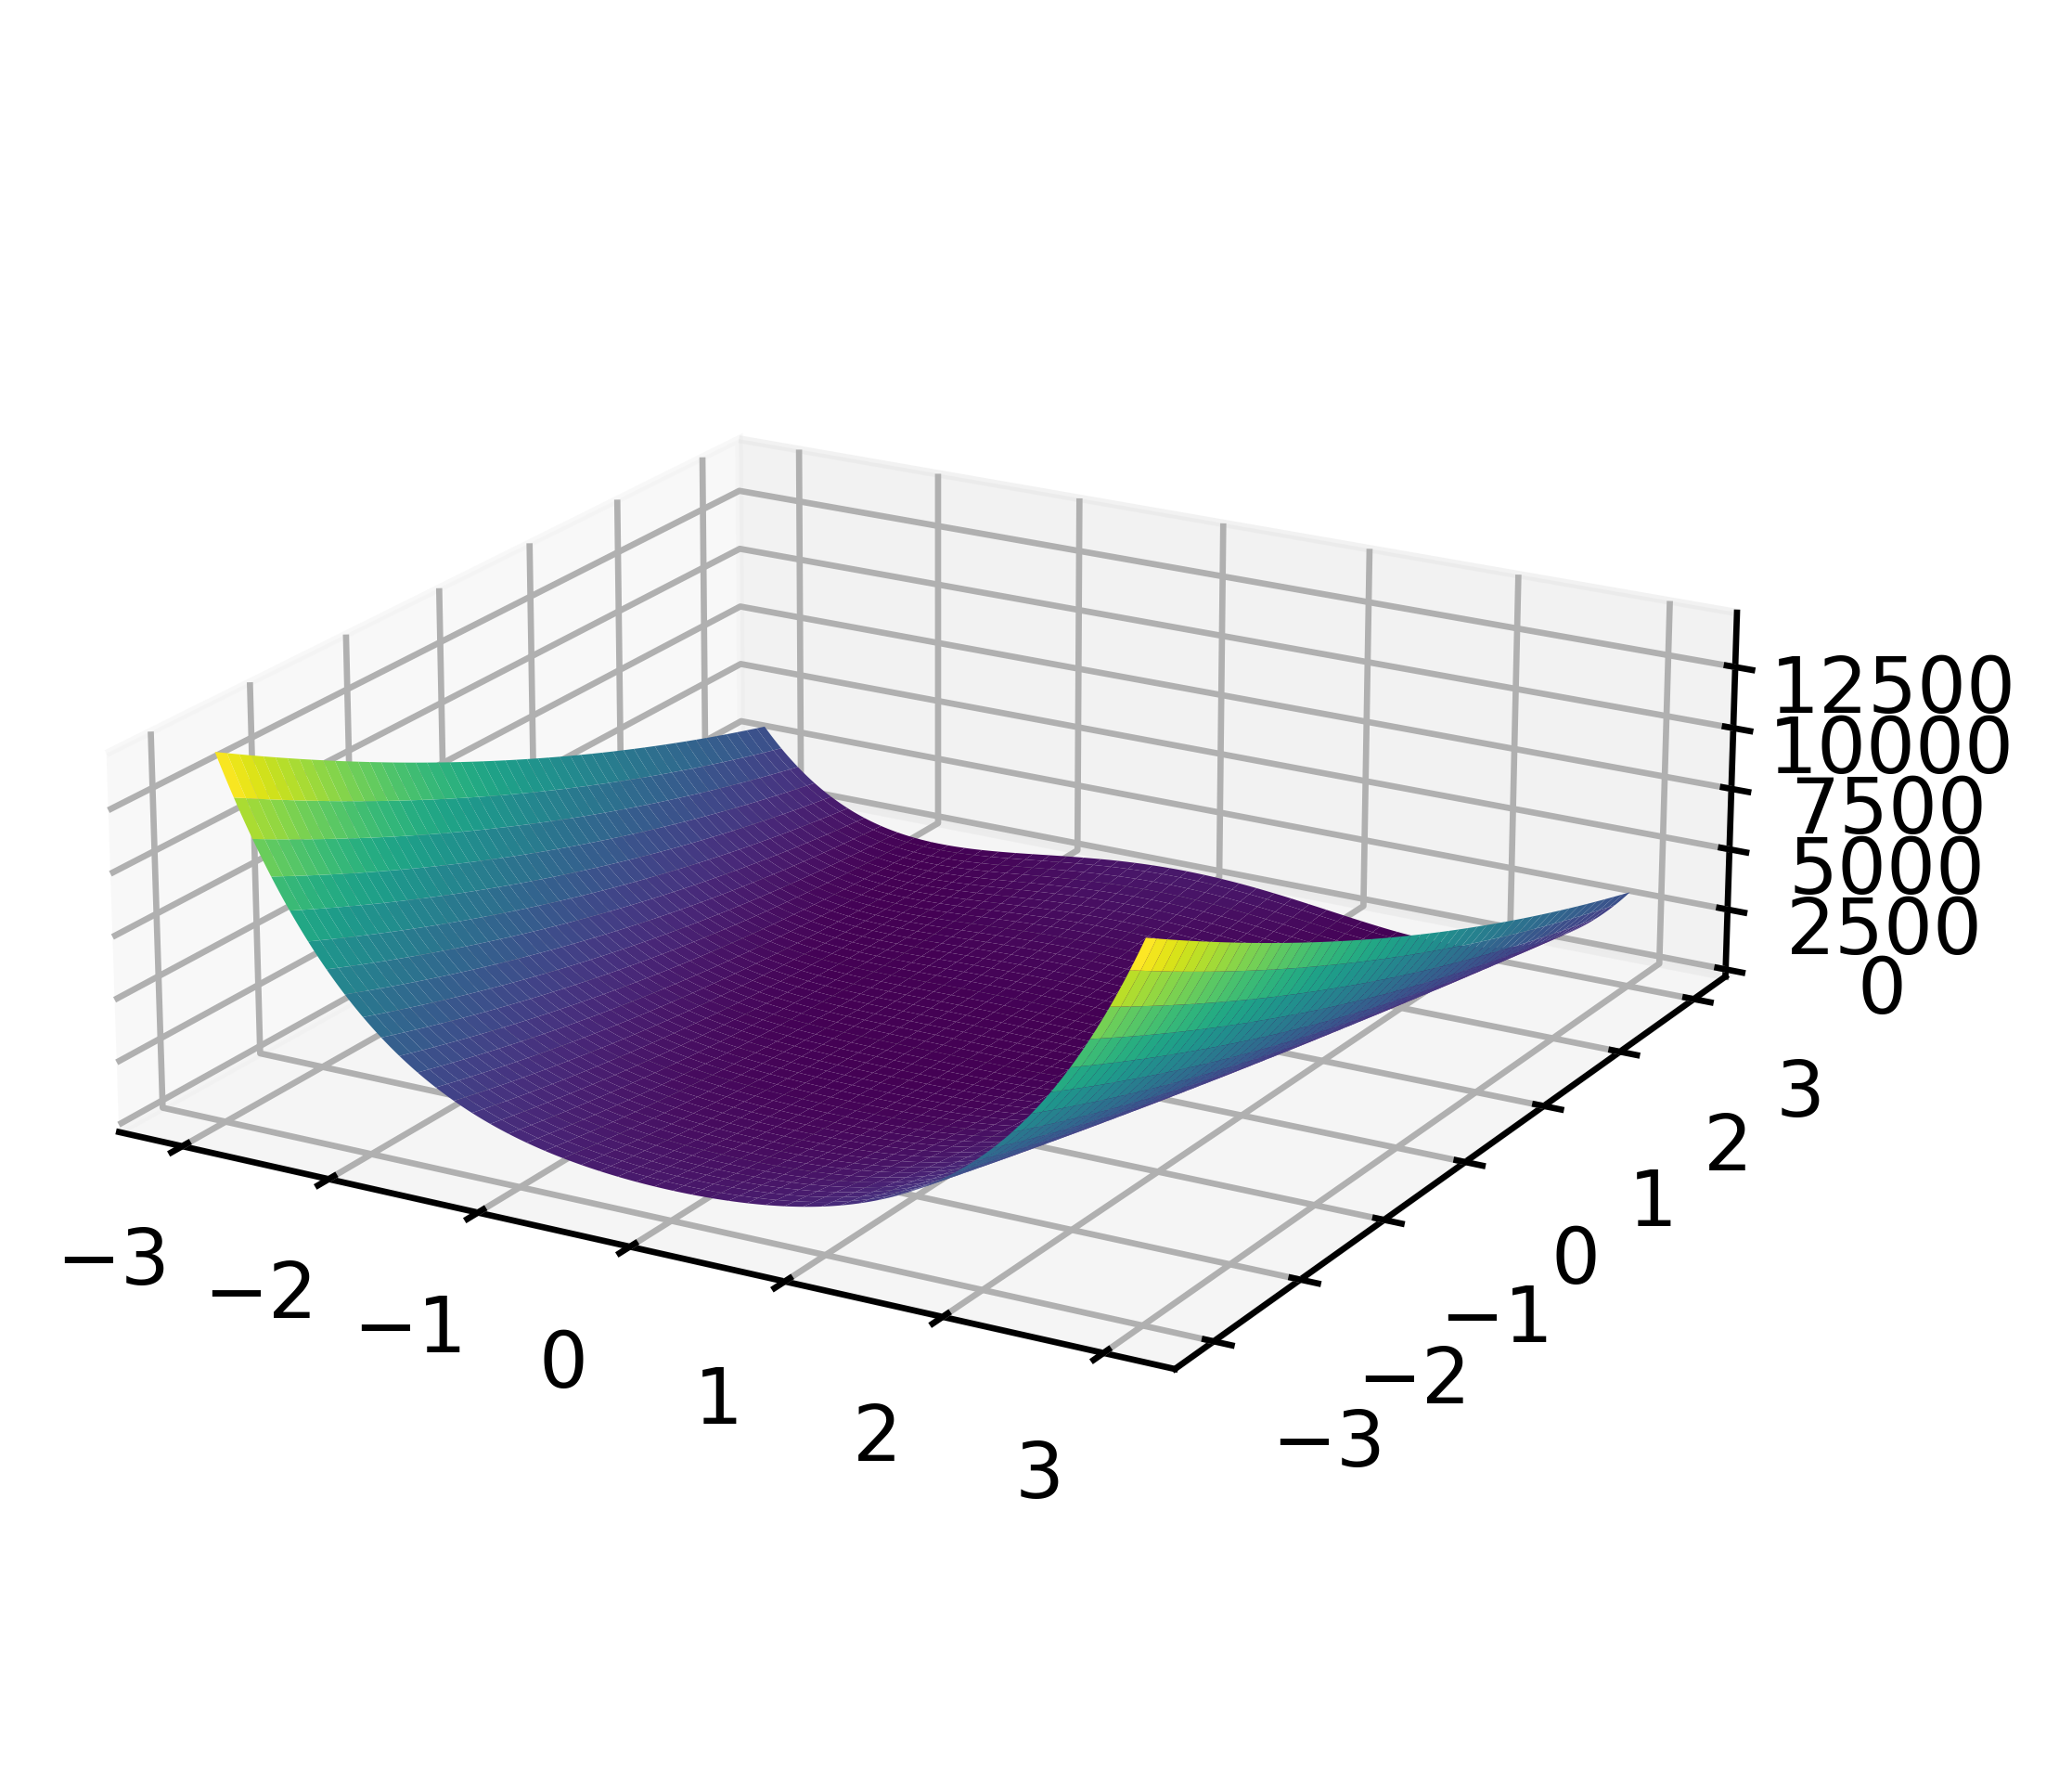

/tmp/ipykernel_782672/3193314055.py:36: RuntimeWarning: divide by zero encountered in log
  plt.contourf(x, y, np.log(z), 100)


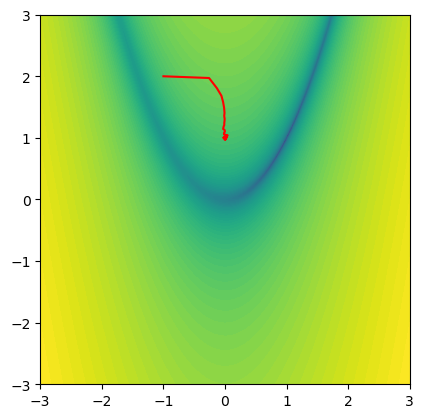

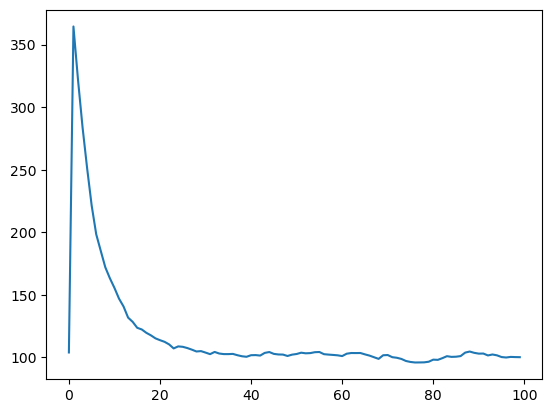

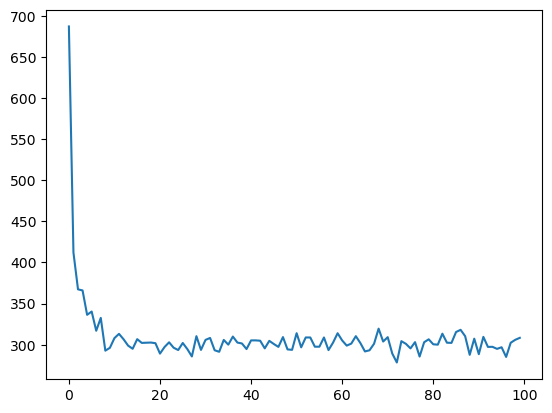

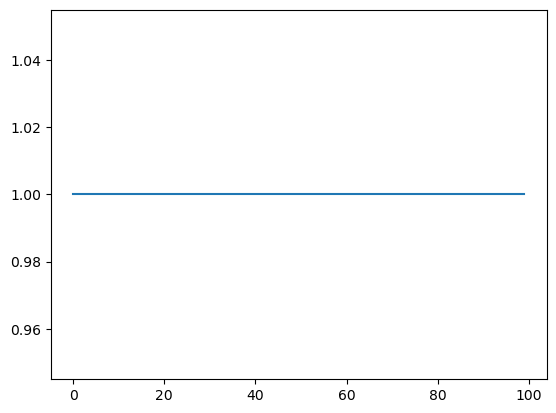

In [310]:
def main():
    f = rosenbrock
    df = dparabola
    
    theta0 = np.array([-1.0, 2.0], dtype=np.float64)
    cont0 = 1e-2

    res = mcdiff_opt(f, df, theta0, cont0)

    #plt.scatter(range(len(res)), res)
    #plt.axhline(y = 90)
    #plt.show()

    print(res.theta_hist[-1])
    print(res.f_hist[-1])

    # 3d plot
    n = 250
    x = np.outer(np.linspace(-3, 3, n), np.ones(n))
    y = np.outer(np.ones(n), np.linspace(-3, 3, n))
    z = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            z[i,j] = f(np.array([x[i,j], y[i,j]]))
    
    fig = plt.figure(figsize=(5, 3), dpi=600)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis', edgecolor=None)
    ax.set_box_aspect((3,3,1))
    ax.elev = 20
    fig.tight_layout(pad=0)
    plt.show()

    # contour plot with optimization path
    fig = plt.figure()
    plt.contourf(x, y, np.log(z), 100)
    plt.plot(res.theta_hist[:,0], res.theta_hist[:,1], 'r')
    ax = plt.gca()
    ax.set_aspect('equal', 'box')
    plt.show()

    # plots of f and g over optimizer step
    plt.plot(range(res.niter), res.f_hist)
    plt.show()
    plt.plot(range(res.niter), res.g_hist)
    plt.show()
    plt.plot(range(res.niter), res.cont_hist)
    plt.show()

if __name__ == "__main__":
    main()